In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [ ]:
import numpy as np
y = y.astype(np.int64)
y

array([5, 0, 4, ..., 4, 5, 6])

### Preprocessing

In [ ]:
X_9s = X[y == 9].reshape(6958, 28, 28)

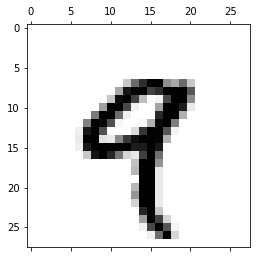

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(X_9s[0], cmap = plt.cm.binary)

In [ ]:
for i in range(len(X_9s)):
    X_9s[i] = np.r_[X_9s[i][2:], np.zeros((2, 28))]

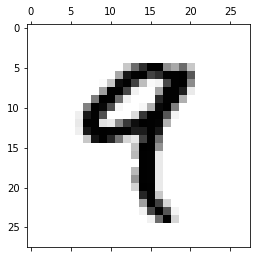

In [ ]:
plt.matshow(X_9s[0], cmap=plt.cm.binary)

In [ ]:
X[y == 9] = X_9s.reshape(6958, 784)

In [ ]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train, X_val, X_test = X[:60000], X[60000:65000], X[65000:]
y_train, y_val, y_test = y[:60000], y[60000:65000], y[65000:]

X_train_scaled = std.fit_transform(X_train)
X_val_scaled = std.transform(X_val)
X_test_scaled = std.transform(X_test)

### Gradient descent for softmax regression

In [ ]:
## Bias trick

X_train_with_bias = np.c_[np.ones((len(X_train), 1)), X_train_scaled]
X_val_with_bias = np.c_[np.ones((len(X_val), 1)), X_val_scaled]
X_test_with_bias = np.c_[np.ones((len(X_test), 1)), X_test_scaled]
X_train_with_bias.shape, X_val_with_bias.shape, X_test_with_bias.shape

((60000, 785), (5000, 785), (5000, 785))

In [ ]:
def convert_to_one_hot(labels):
    n_classes = np.max(labels) + 1
    m = len(labels)
    one_hot = np.zeros((m, n_classes))
    for i in range(m):
        one_hot[i][labels[i]] = 1
    return one_hot

In [ ]:
Y_train_one_hot = convert_to_one_hot(y_train)
Y_val_one_hot = convert_to_one_hot(y_val)
Y_test_one_hot = convert_to_one_hot(y_test)

In [ ]:
def softmax(logits):
    exps = np.exp(logits)
    return exps / np.sum(exps, axis=1, keepdims=True)

In [ ]:
n_inputs = X_train.shape[1] + 1
n_outputs = len(np.unique(y))
n_inputs, n_outputs

(785, 10)

In [ ]:
# # EARLY STOPPING
# np.random.seed(25)
# eta = 0.1
# n_iterations = 10001
# m = len(X_train)
# epsilon = 1e-7
# best_loss = np.infty

# Theta_et = np.random.randn(n_inputs, n_outputs)

# for it in range(n_iterations):
#     logits = X_train_with_bias.dot(Theta_et)
#     Y_proba = softmax(logits)
#     error = Y_proba - Y_train_one_hot
#     gradients = 1/m * X_train_with_bias.T.dot(error) 
#     Theta_et = Theta_et - eta * gradients

#     logits = X_val_with_bias.dot(Theta_et)
#     Y_proba = softmax(logits)
#     loss = -np.mean(np.sum(Y_val_one_hot * np.log(Y_proba + epsilon), axis=1))

#     if it % 50 == 0:
#         print(it, loss)
#     if loss < best_loss:
#         best_loss = loss
#     else:
#         print(it - 1, best_loss)
#         print(it, loss, 'Early stopping')
#         break

In [ ]:
# Mini batch gradient descent
# np.random.seed(25)
eta = 0.1
n_epochs = 100
minibatch_size = 30
m = len(X_train)
epsilon = 1e-7
loss_mgd = []

#theta = np.random.rand(n_inputs, n_outputs)

for epoch in range(n_epochs):
    random_indices = np.random.permutation(m)
    X_shuffle = X_train_with_bias[random_indices]
    y_shuffle = Y_train_one_hot[random_indices]
    for i in range(0, m, minibatch_size):
        xi = X_shuffle[i:i+minibatch_size]
        yi = y_shuffle[i:i+minibatch_size]
        logits = xi.dot(theta)
        Y_proba = softmax(logits)

        loss = -np.mean(np.sum(yi * np.log(Y_proba + epsilon), axis=1))
        #if i % 3000 == 0:
           #print("Loss: ", loss)
        loss_mgd.append(loss)

        error = Y_proba - yi
        gradients = 1/m * xi.T.dot(error)
        theta = theta - eta*gradients
        
        

(199990.0, 200000.0, 0.0, 3.0)

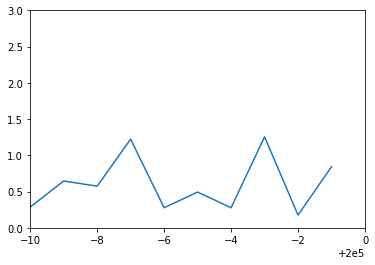

In [ ]:
plt.plot([i for i in range(len(loss_mgd))], loss_mgd)
plt.axis([199990, 200000, 0, 3])

In [ ]:
# Evaluation

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
def display_score(precision, recall, f1_score):
    score = np.array([[str(i) for i in range(10)], np.round(precision*100, 2), np.round(recall*100, 2), np.round(f1_score*100, 2)])
    df = pd.DataFrame(data=score.T, columns=['Labels', 'Precision', 'Recall', 'F1_score'])
    return df.set_index('Labels')


In [ ]:
# on training set
logits = X_train_with_bias.dot(theta)
Y_proba = softmax(logits)
y_pred = np.argmax(Y_proba, axis=1)
precision, recall, f1score, sp = score(y_train, y_pred)
display_score(precision, recall, f1score)

,Precision,Recall,F1_score
Labels,,,
0,96.24,97.18,96.71
1,94.81,97.32,96.05
2,92.99,91.27,92.12
3,92.32,90.44,91.37
4,95.15,95.99,95.57
5,90.79,89.65,90.22
6,94.54,95.94,95.24
7,95.96,96.38,96.17
8,90.64,88.84,89.73


In [ ]:
accuracy_score(y_train, y_pred)

0.9437833333333333

In [ ]:
# on validation set
logits = X_val_with_bias.dot(theta)
Y_proba = softmax(logits)
y_pred = np.argmax(Y_proba, axis=1)
precision, recall, f1score, sp = score(y_val, y_pred)
display_score(precision, recall, f1score)

,Precision,Recall,F1_score
Labels,,,
0,93.22,95.65,94.42
1,92.38,97.72,94.98
2,89.76,86.04,87.86
3,86.8,89.4,88.08
4,93.1,94.4,93.74
5,87.38,82.02,84.62
6,89.13,90.48,89.8
7,92.53,91.99,92.26
8,88.43,82.82,85.53


In [ ]:
accuracy_score(y_val, y_pred)

0.9122

In [ ]:
# on test set
logits = X_test_with_bias.dot(theta)
Y_proba = softmax(logits)
y_pred = np.argmax(Y_proba, axis=1)
precision, recall, f1score, sp = score(y_test, y_pred)
display_score(precision, recall, f1score)

,Precision,Recall,F1_score
Labels,,,
0,96.94,97.5,97.22
1,97.34,97.16,97.25
2,94.15,89.84,91.95
3,95.15,92.35,93.73
4,96.26,96.06,96.16
5,92.92,90.37,91.63
6,93.22,96.98,95.06
7,96.89,96.71,96.8
8,87.18,92.58,89.8


In [ ]:
accuracy_score(y_test, y_pred)

0.95

In [ ]:
import joblib
joblib.dump(std, 'std.pkl')

['std.pkl']

#### Save and download weights

In [ ]:
with open('weights_mgd.txt', 'w') as f:
    for i in theta:
        for j in i:
            f.write(str(j) + " ")

In [ ]:
# Theta_et = []
# with open('/content/drive/MyDrive/weights_et.txt', 'r') as f:
#     weights = [float(i) for i in f.read().split()]

# for i in range(0, len(weights), 10):
#     Theta_et.append(weights[i:i+10])

# Theta_et = np.array(Theta_et)
# print(Theta_et.shape)

### USE KNN

In [ ]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix


clf_knn = neighbors.KNeighborsClassifier(n_neighbors = 3, p = 2) # K = 3, accuracy_score = 0.9705
clf_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred_knn = clf_knn.predict(X_train_scaled)
precision, recall, f1_score, support = score(y_train, y_pred_knn)
display_score(precision, recall, f1_score)

,Precision,Recall,F1_score
Labels,,,
0,97.72,99.26,98.48
1,97.2,99.5,98.34
2,97.04,97.01,97.03
3,96.78,97.42,97.1
4,97.82,97.57,97.69
5,97.0,96.14,96.57
6,98.08,98.58,98.33
7,97.79,98.32,98.06
8,99.0,94.38,96.63


In [ ]:
accuracy_score(y_train, y_pred_knn)

0.9775666666666667

In [ ]:
# valid set
y_pred_knn = clf_knn.predict(X_val_scaled)
precision, recall, f1_score, support = score(y_val, y_pred_knn)
display_score(precision, recall, f1_score)

,Precision,Recall,F1_score
Labels,,,
0,93.05,98.91,95.89
1,93.39,98.95,96.09
2,93.33,92.45,92.89
3,89.45,95.0,92.14
4,95.17,94.6,94.88
5,93.84,90.13,91.95
6,95.83,94.59,95.21
7,94.04,92.38,93.2
8,95.67,85.89,90.52


In [ ]:
accuracy_score(y_val, y_pred_knn)

0.9398

In [ ]:
# test set
y_pred_knn = clf_knn.predict(X_test_scaled)
precision, recall, f1_score, support = score(y_test, y_pred_knn)
display_score(precision, recall, f1_score)

,Precision,Recall,F1_score
Labels,,,
0,97.33,98.27,97.8
1,96.4,99.65,97.99
2,96.18,95.42,95.8
3,96.25,95.49,95.87
4,97.09,96.89,96.99
5,93.89,95.18,94.53
6,97.6,98.19,97.89
7,97.86,97.48,97.67
8,96.6,93.61,95.08


In [ ]:
accuracy_score(y_test, y_pred_knn)

0.9686

### USE SKLEARN (Logistic Regression)


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=1, max_iter=10001000, multi_class='multinomial')

In [ ]:
# on training set
y_pred_log = log_reg.predict(X_train_scaled)
precision, recall, f1_score, support= score(y_train, y_pred_log)
display_score(precision, recall, f1_score)

,Precision,Recall,F1_score
Labels,,,
0,97.98,98.14,98.06
1,97.14,98.21,97.67
2,94.43,93.37,93.9
3,93.52,92.2,92.85
4,96.71,97.19,96.95
5,92.32,91.83,92.07
6,96.48,97.13,96.8
7,97.66,97.92,97.79
8,91.57,91.76,91.67


In [ ]:
accuracy_score(y_train, y_pred_log)

0.95845

In [ ]:
# on valid set
y_pred_log = log_reg.predict(X_val_scaled)
precision, recall, f1_score, support= score(y_val, y_pred_log)
display_score(precision, recall, f1_score)

,Precision,Recall,F1_score
Labels,,,
0,92.53,96.96,94.69
1,94.76,98.25,96.47
2,90.04,86.98,88.48
3,86.4,90.2,88.26
4,93.81,94.0,93.91
5,86.35,84.65,85.49
6,94.22,91.77,92.98
7,93.03,91.21,92.11
8,87.71,84.66,86.16


In [ ]:
accuracy_score(y_val, y_pred_log)

0.92

In [ ]:
# on test set
y_pred_log = log_reg.predict(X_test_scaled)
precision, recall, f1_score, support= score(y_test, y_pred_log)
display_score(precision, recall, f1_score)

,Precision,Recall,F1_score
Labels,,,
0,97.29,96.73,97.01
1,96.99,97.16,97.08
2,94.2,90.64,92.39
3,93.68,92.94,93.31
4,96.89,97.1,96.99
5,92.74,90.83,91.77
6,94.9,97.58,96.22
7,97.27,96.51,96.89
8,88.78,92.99,90.84


In [ ]:
accuracy_score(y_test, y_pred_log)

0.9532

### SVM

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier

# train with LinearSVC first
lin_clf = LinearSVC(random_state=25, max_iter=10000)
lin_clf.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(max_iter=10000, random_state=25)

In [ ]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9453833333333334

In [ ]:
y_pred = lin_clf.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.9174

In [ ]:
# use SVC with kernel rbf
svm_clf = SVC(kernel='rbf', probability=True)
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC()

In [ ]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.95575

In [ ]:
y_pred = svm_clf.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.9396

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {
    'gamma': reciprocal(0.001, 0.1),
    'C': uniform(1, 10)
}

rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=1000, cv=3, verbose=2)
rnd_search_cv.fit(X_train_scaled[:2000], y_train[:2000])

In [ ]:
rnd_search_cv.best_estimator_

SVC(C=4.524746067941309, gamma=0.001027258374541153)

In [ ]:
rnd_search_cv.best_score_

0.913012712862788

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=4.524746067941309, gamma=0.001027258374541153)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9968333333333333

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.9732

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.983

In [ ]:
precision, recall, f1_score, sp = score(y_test, y_pred)
display_score(precision, recall, f1_score)

,Precision,Recall,F1_score
Labels,,,
0,99.03,98.46,98.75
1,99.82,99.29,99.56
2,98.19,97.41,97.8
3,98.81,97.84,98.33
4,99.16,98.55,98.86
5,96.82,97.71,97.26
6,98.39,98.79,98.59
7,95.67,98.45,97.04
8,96.9,96.7,96.8


In [ ]:
best_model = rnd_search_cv.best_estimator_
joblib.dump(best_model, 'svm_clf.pkl')

['svm_clf.pkl']